In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import normalize, OneHotEncoder


Read the training and test data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
#extract cabin letters and numbers
def feature_extraction(df):
    def get_surname(x):
        return x['Name'].apply(lambda x: x.split(',')[0])
    def get_prefix(x):
        return x['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    def firstname_split(x):
        res = x.split(',')[1].split('.')[1].strip().split(' ')[0]
        return res.replace('(', '').replace(')', '')
    def get_firstname(x):
        return x['Name'].apply(firstname_split)
    def extract_cabin_letter(x):
        if x is np.nan: 
            return ''
        else: 
            return x[0].upper()
    def extract_cabin_num(x):
        if x is np.nan: 
            return ''
        else: 
            return x[1:]
    def get_ticket_pre(x):
        #if it is int, then this is actually the ticket number so ignore for next function
        res = x.split(' ')[0]
        try:
            res = int(res)
            return ''
        except:
            if '/' in res:
                return res.split('/')[0]
            else:
                return res
    def get_ticket_num(x):
        res = x.split(' ')[-1]
        return res
    df['Cabin_L']   = df['Cabin'].apply(extract_cabin_letter)
    df['Cabin_N']   = df['Cabin'].apply(extract_cabin_num)
    df['Surname']   = get_surname(df)
    df['Prefix']    = get_prefix(df)
    df['Firstname'] = get_firstname(df)
    df['Ticket_C']  = df['Ticket'].apply(get_ticket_pre)
    df['Ticket_N']  = df['Ticket'].apply(get_ticket_num)
    df['Ticket_Level'] = df['Ticket_N'].apply(lambda x: x[0])
    df['Name_Len'] = df['Name'].apply(lambda x: len(x))
    df['Prefix_Len'] = df['Prefix'].apply(lambda x: len(x))
    df['Firstame_Len'] = df['Firstname'].apply(lambda x: len(x))
    df['Surname_Len'] = df['Surname'].apply(lambda x: len(x))

    return df

In [15]:
train_df = feature_extraction(train_df)
test_df = feature_extraction(test_df)

In [16]:
train_df[train_df.isna().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Prefix,Firstname,Ticket_C,Ticket_N,Ticket_Level,Name_Len,Prefix_len,Firstame_Len,Surname_Len,Prefix_Len
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,Owen,A,21171,2,23,2,4,6,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,Laina,STON,3101282,3,22,4,5,9,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,William,,373450,3,24,2,7,5,2
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,...,Mr,James,,330877,3,16,2,5,5,2
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,Master,Gosta,,349909,3,30,6,5,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,...,Mr,Henry,SOTON,392076,3,22,2,5,8,2
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,...,Mrs,William,,382652,3,36,3,7,4,3
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,Rev,Juozas,,211536,2,21,3,6,8,3
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,Miss,Catherine,W.,6607,6,40,4,9,8,4


In [17]:
Counter(train_df['Prefix'])

Counter({'Mr': 517,
         'Mrs': 125,
         'Miss': 182,
         'Master': 40,
         'Don': 1,
         'Rev': 6,
         'Dr': 7,
         'Mme': 1,
         'Ms': 1,
         'Major': 2,
         'Lady': 1,
         'Sir': 1,
         'Mlle': 2,
         'Col': 2,
         'Capt': 1,
         'the Countess': 1,
         'Jonkheer': 1})

<AxesSubplot:xlabel='Prefix'>

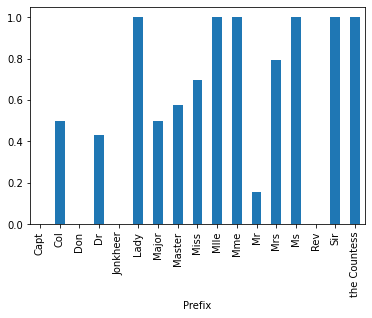

In [18]:
train_df.groupby('Prefix').mean()['Survived'].plot.bar()

In [19]:
def pre_process(df, columns, cat_cols, scale_cols):
    X = df[columns].copy()
    y = None
    if 'Survived' in df.columns:
        y = df.Survived
    for c in cat_cols:#X.columns:
        #col_type = X[c].dtype
        #if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
    #X['Age'].fillna(X['Age'].median(), inplace = True)
    #X['Fare'].fillna(X['Fare'].median(), inplace = True)
    #print(X.isna().any())
    scaled_X = X.copy()
    def my_standardize(x):
        return (x - x.min())/x.std()
    def my_normalize(x):
        return (x - x.min())/(x.max()-x.min())
    #arr = normalize(np.array(X[scale_cols[0]]).reshape(-1,1))
    #print(np.isnan(arr).any())
    #for c in scale_cols:
    #    scaled_X[c] = my_normalize(scaled_X[c])
    #    scaled_X[c] = normalize(np.array(X[c]).reshape(-1,1))
    return scaled_X, y

In [49]:
columns  = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex', 'Embarked', 'Surname', 'Prefix', 'Firstname', 
            'Name_Len', 'Firstame_Len', 'Surname_Len', 'Prefix_Len', 
                'Cabin_L', #'Cabin_N', 'Ticket_N', 
                'Ticket_C', 'Ticket_Level']
scale_cols = ['Age', 'Fare', 'Name_Len']
cat_cols = ['Pclass', 'Sex', 'Surname', 'Prefix', 'Embarked', 'Firstname', 'Cabin_L', 'Ticket_C', 'Ticket_Level']
    

In [50]:
X_train, y_train = pre_process(train_df, columns, cat_cols, scale_cols)
X_test, _        = pre_process(test_df, columns, cat_cols, scale_cols)

In [51]:
Counter(y_train)

Counter({0: 549, 1: 342})

In [52]:
lgb = lightgbm.LGBMClassifier()

In [53]:
lgb.fit(X_train, y_train)

LGBMClassifier()

In [54]:
predicted_y = lgb.predict(X_train)


In [55]:
print(classification_report(y_train, predicted_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       549
           1       0.99      1.00      1.00       342

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891



In [56]:
print(confusion_matrix(y_train, predicted_y))

[[547   2]
 [  1 341]]


In [57]:
print(confusion_matrix(y_train, predicted_y))

[[547   2]
 [  1 341]]


In [58]:
probs = lgb.predict_proba(X_train)

In [59]:
fpr, tpr, thresholds = roc_curve(y_train, probs[:,1])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


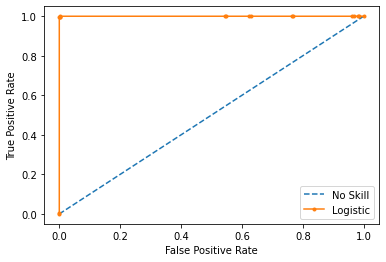

In [60]:
ns_probs = [0 for _ in range(len(y_train))]
lr_probs = probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [61]:
lgb.score(X_train, y_train)

0.9966329966329966

In [62]:
lgb.score

<bound method ClassifierMixin.score of LGBMClassifier()>

In [63]:
lgb.feature_importances_

array([813,  65,  35, 666,  99,  72,  91,   0,   7,  16, 503, 202, 318,
        61,  20,  10,  22])

In [64]:
idx = np.where(y_train != predicted_y)
idx

(array([ 36, 382, 826], dtype=int64),)

In [65]:
probs[idx]

array([[0.56468926, 0.43531074],
       [0.43811141, 0.56188859],
       [0.43833681, 0.56166319]])

In [66]:
train_df.iloc[idx]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Prefix,Firstname,Ticket_C,Ticket_N,Ticket_Level,Name_Len,Prefix_len,Firstame_Len,Surname_Len,Prefix_Len
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,...,Mr,Hanna,,2677,2,16,2,5,5,2
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,...,Mr,Juho,STON,3101293,3,18,2,4,8,2
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,...,Mr,Len,,1601,1,12,2,3,3,2


In [67]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Firstname,Ticket_C,Ticket_N,Ticket_Level,Name_Len,Prefix_len,Firstame_Len,Surname_Len,Prefix_Len,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,James,,330911,3,16,2,5,5,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,James,,363272,3,32,3,5,6,3,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,Thomas,,240276,2,25,2,6,5,2,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,Albert,,315154,3,16,2,6,4,2,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,Alexander,,3101298,3,44,3,9,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,...,Woolf,A.5.,3236,3,18,2,5,7,2,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,Fermina,PC,17758,1,28,4,7,13,4,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,Simon,SOTON,3101262,3,28,2,5,7,2,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,...,Frederick,,359309,3,19,2,9,4,2,0


In [68]:
X_train

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,Surname,Prefix,Firstname,Name_Len,Firstame_Len,Surname_Len,Prefix_Len,Cabin_L,Ticket_C,Ticket_Level
0,22.0,1,0,7.2500,3,male,S,Braund,Mr,Owen,23,4,6,2,,A,2
1,38.0,1,0,71.2833,1,female,C,Cumings,Mrs,John,51,4,7,3,C,PC,1
2,26.0,0,0,7.9250,3,female,S,Heikkinen,Miss,Laina,22,5,9,4,,STON,3
3,35.0,1,0,53.1000,1,female,S,Futrelle,Mrs,Jacques,44,7,8,3,C,,1
4,35.0,0,0,8.0500,3,male,S,Allen,Mr,William,24,7,5,2,,,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,2,male,S,Montvila,Rev,Juozas,21,6,8,3,,,2
887,19.0,0,0,30.0000,1,female,S,Graham,Miss,Margaret,28,8,6,4,B,,1
888,NaN,1,2,23.4500,3,female,S,Johnston,Miss,Catherine,40,9,8,4,,W.,6
889,26.0,0,0,30.0000,1,male,C,Behr,Mr,Karl,21,4,4,2,C,,1


In [69]:
test_df['Survived'] = lgb.predict(X_test)

In [70]:
from datetime import datetime
now_str = datetime.now().strftime("%Y%m%d-%H%M%S")

In [71]:
test_df[['PassengerId', 'Survived']].to_csv(f'data/titanic_submission{now_str}.csv', index = False)

In [72]:
test_df[['PassengerId', 'Survived']]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
